В этом уроке применим линейную регрессию на практике – попробуем предсказать стоимость машин и понять, от каких факторов зависит ценообразование на автомобили. Помимо этого узнаем, какие переменные важны для прогнозирования и насколько хорошо полученная модель описывает данные.

### 1. Загрузите данные, проверьте правильность, наличие пропущенных значений, типы данных.

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg #лучше показывает

exp1 = pd.read_csv('F:\\карпов\\6 СТАТИСТИКА\\7 Модели\\cars.csv')
sns.set(rc={'figure.figsize': (16,6),'figure.dpi': (75)},style='darkgrid')

# сводная таблица
lst = []
for name in exp1.columns:
    nu = len(exp1[name].unique())
    nisnan = exp1[name].isnull().sum()
    values_sample = exp1[name].unique()[:min(nu, 10)].tolist()
    dtype = exp1[name].dtype# Получаем тип данных каждой колонки
    lst.append([name,dtype, nu, nisnan, values_sample])
    
result_df = pd.DataFrame(lst, columns=['column','dtype', 'nunique', 'nnull', 'values'])
result_df.sort_values(by='nunique')

,column,dtype,nunique,nnull,values
3,fueltype,object,2,0,"[gas, diesel]"
4,aspiration,object,2,0,"[std, turbo]"
5,doornumber,object,2,0,"[two, four]"
8,enginelocation,object,2,0,"[front, rear]"
7,drivewheel,object,3,0,"[rwd, fwd, 4wd]"
6,carbody,object,5,0,"[convertible, hatchback, sedan, wagon, hardtop]"
1,symboling,int64,6,0,"[3, 1, 2, 0, -1, -2]"
14,enginetype,object,7,0,"[dohc, ohcv, ohc, l, rotor, ohcf, dohcv]"
15,cylindernumber,object,7,0,"[four, six, five, three, twelve, two, eight]"
17,fuelsystem,object,8,0,"[mpfi, 2bbl, mfi, 1bbl, spfi, 4bbl, idi, spdi]"


### 2. Создайте новый признак – марку автомобиля (company). Машины каких производителей встречаются в датасете? Далее исправьте названия и проверьте изменения.

In [24]:
exp1['company'] = exp1.CarName.apply(lambda x: x.split(' ')[0])
exp1['CarName'] = exp1.CarName.apply(lambda x: x.split(' ')[1] if len(x.split(' ')) > 1 else x)
exp1['company'].nunique()

28

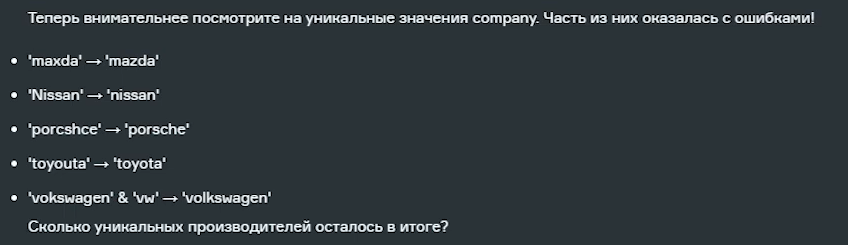

In [25]:
exp1.company = exp1.company.str.lower()

In [26]:
def fix_car_marks(to_rep,how_rep):
    exp1.company.replace(to_rep,how_rep, inplace=True)

fix_car_marks('maxda','mazda')
fix_car_marks('porcshce','porsche')
fix_car_marks('toyouta','toyota')
fix_car_marks('vw','volkswagen')
fix_car_marks('vokswagen','volkswagen')


In [27]:
exp1['company'].nunique()

22

### 3. Оставьте только часть предикторов, после чего посчитайте корреляцию между price и другими переменными.

In [28]:
exp1.drop(['car_ID','CarName'],axis=1,inplace=True)

In [29]:
categorical_columns = exp1.select_dtypes(include=['object', 'category']).columns
corr_with_price = exp1.drop(categorical_columns,axis=1).corr()['price'].abs().sort_values(ascending=False)[:10].round(2)
corr_with_price

price         1.00
enginesize    0.87
curbweight    0.84
horsepower    0.81
carwidth      0.76
highwaympg    0.70
citympg       0.69
carlength     0.68
wheelbase     0.58
boreratio     0.55
Name: price, dtype: float64

### 4. Преобразуйте категориальные переменные с помощью pd.get_dummies(). 

In [30]:
dummies = pd.get_dummies(exp1,drop_first=True, dtype='int32')
dummies.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,...,company_nissan,company_peugeot,company_plymouth,company_porsche,company_renault,company_saab,company_subaru,company_toyota,company_volkswagen,company_volvo
0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,0,0,0,0,0,0,0,0,0,0
1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,...,0,0,0,0,0,0,0,0,0,0
2,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,...,0,0,0,0,0,0,0,0,0,0
3,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,...,0,0,0,0,0,0,0,0,0,0
4,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,...,0,0,0,0,0,0,0,0,0,0


### 5. Постройте модель с одним предиктором цены – horsepower. Какой процент изменчивости объясняет полученная модель? (\(R^2\))

In [31]:
from scipy import stats
import statsmodels.api as sm

stats.linregress(exp1.horsepower, exp1.price)
#slope - tick cost
#intercept - начало цены если horsepower = 0
#rvalue - коэффициент корреляции
#pvalue - меньше 0.05 есть значимая стат связь в данном случае линейная зависимость
#stderr  и intercept_stderr - Это стандартные ошибки для наклона и пересечения. 
# Они указывают на насколько точны коэффициенты регрессии. 
# Чем меньше эти значения, тем более точны коэффициенты.

LinregressResult(slope=163.26306096964794, intercept=-3721.76149432276, rvalue=0.8081388225362214, pvalue=1.4834365732942122e-48, stderr=8.35147880825741, intercept_stderr=929.8492418134907)

In [32]:
import statsmodels.formula.api as smf
# то же самое можно через формулу
results = smf.ols('price ~ horsepower', exp1).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     382.2
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.48e-48
Time:                        18:33:01   Log-Likelihood:                -2024.0
No. Observations:                 205   AIC:                             4052.
Df Residuals:                     203   BIC:                             4059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3721.7615    929.849     -4.003      0.0

In [33]:
from sklearn.linear_model import LinearRegression
x = exp1.horsepower.values.reshape(-1, 1)
y = exp1.price
model = LinearRegression()
model.fit(x,y)
print(model.score(x,y).round(3))

0.653


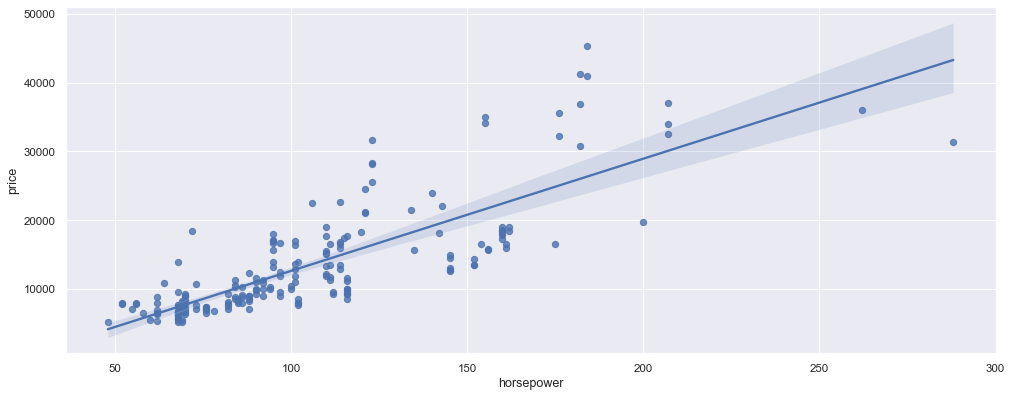

In [34]:
sns.regplot(data=exp1,x='horsepower',y='price');

### 6. Далее – две модели (со всеми предикторами и со всеми, кроме марок машин). Обратите внимание на изменения в \(R^2\), коэффициентах и их значимости. Какую модель лучше оставить? 

In [35]:
x = dummies.drop('price',axis=1)
y = dummies.price
model = LinearRegression()
model.fit(x,y)
print(model.score(x,y).round(3))

0.966


In [36]:
X = sm.add_constant(x) # добавить константу, чтобы был свободный член
model = sm.OLS(y, X) # говорим модели, что у нас ЗП, а что НП

results = model.fit() # строим регрессионную прямую
print(results.summary()) # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     68.86
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           6.09e-82
Time:                        18:33:01   Log-Likelihood:                -1784.9
No. Observations:                 205   AIC:                             3692.
Df Residuals:                     144   BIC:                             3895.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.822e+

#### без марок машин

In [40]:
exp2 = exp1.drop('company',axis=1)
categorical_columns_1 = exp2.select_dtypes(include=['object','category']).columns
dummies_1 = pd.get_dummies(exp2,columns=categorical_columns_1,drop_first=True,dtype='int16')
x = dummies_1.drop('price',axis=1)
y = dummies_1.price
model_1 = LinearRegression()
model_1.fit(x,y)
model_1.score(x,y).round(2)

0.94

In [38]:
X = sm.add_constant(x) # добавить константу, чтобы был свободный член
model_1 = sm.OLS(y, X) # говорим модели, что у нас ЗП, а что НП

results = model_1.fit() # строим регрессионную прямую
print(results.summary()) # смотрим результат

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     61.79
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           4.86e-80
Time:                        18:33:02   Log-Likelihood:                -1844.9
No. Observations:                 205   AIC:                             3774.
Df Residuals:                     163   BIC:                             3913.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.876e+

- Если судить чисто по диагностическим показателям(вроде R2), то модель со всеми предикторами лучшая
- Большинство коэффициентов, связанных с марками машин, статистически незначимы

### 7.	Заполните пропуски в результатах.

Поискать источники мультиколлинеарности:

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor # фактор вздутия дисперсии

# делаем датафрейм
vif_data = pd.DataFrame()
vif_data['features'] = X.columns

# считаем для каждого
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [43]:
vif_data

,features,VIF
0,const,0.000000
1,symboling,3.729848
2,wheelbase,14.340698
3,carlength,15.284346
4,carwidth,11.142078
5,carheight,4.122954
6,curbweight,33.675355
7,enginesize,49.505517
8,boreratio,7.910548
9,stroke,3.372270


нужно поработать с inf, они мешают модели. допдиагностика: [statsmodels(manual)](https://www.statsmodels.org/dev/examples/index.html#plotting)